In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install tensorflow_addons

In [ ]:
import json
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import keras
import keras.layers as layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, TFBertModel

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_train.csv')
df_val = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_val.csv')
df_test = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_test.csv')

In [ ]:
target_entities = ['LOCATION1', 'LOCATION2']
aspects = ['general','price','safety','transit-location']

Number of words

26.0

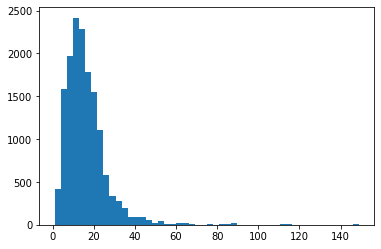

In [ ]:
lens = [len(x.split()) for x in df_train["text"].tolist()]
plt.hist(lens, 50);
np.percentile(np.array(lens), 90)

### BERT config

In [ ]:
MAX_SEQ_LEN = int(np.percentile(np.array(lens), 90))
BERT_NAME = 'bert-base-uncased'

In [ ]:
def prepare_bert_input(sentences, seq_len, bert_name):
    '''
    Function to pre-process and tokenize texts.
    Returns input_ids and attention masks for BERT inputs
    '''
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length', max_length=seq_len, add_special_tokens=True, return_tensors='tf', return_token_type_ids = False, return_attention_mask = True)
    input = [np.array(encodings["input_ids"]), np.array(encodings["attention_mask"])]
    return input

def create_model():
    '''
    Function to return Model: BERT with classifier
    Multi-Task Learning
    '''
    bert = TFBertModel.from_pretrained(BERT_NAME)

    input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_mask]
    
    bert_outputs = bert(inputs)[0]
    x = layers.GlobalAveragePooling1D()(bert_outputs)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    output_general = layers.Dense(3, activation="softmax", name="output_general")(x)
    output_price = layers.Dense(3, activation="softmax", name="output_price")(x)
    output_safety = layers.Dense(3, activation="softmax", name="output_safety")(x)
    output_transit = layers.Dense(3, activation="softmax", name="output_transit")(x)

    model = keras.Model(inputs=inputs, outputs=[output_general, output_price, output_safety, output_transit])
    model.layers[2].trainable = True

    model.summary()
    plot_model(model)
    return model

def fine_tune(model, X_train, x_val, y_train, y_val, max_epochs=3, batch_size=64, lr=2e-05):
    '''
    Function to fit model
    '''
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy()

    best_weights_file = "weights.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='loss', mode='max', verbose=2, save_weights_only=True, save_best_only=True)

    model.compile(loss={"output_general":loss, "output_price":loss, "output_safety":loss, "output_transit":loss}, 
                  optimizer=opt,
                  metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'acc'])
    
    model.fit(X_train, {"output_general":y_train[:, 0], "output_price":y_train[:, 1], "output_safety":y_train[:, 2], "output_transit":y_train[:, 3]},
              validation_data =(x_val, {"output_general":y_val[:, 0], "output_price":y_val[:, 1], "output_safety":y_val[:, 2], "output_transit":y_val[:, 3]}),
              epochs=max_epochs, batch_size=batch_size, callbacks=[m_ckpt], verbose=2)

def load_model(lr=2e-05):
    model = create_model()
    loss = keras.losses.CategoricalCrossentropy()
    best_weights_file = "weights.h5"
    model.load_weights(best_weights_file)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss={"output_general":loss, "output_price":loss, "output_safety":loss, "output_transit":loss}, 
                  optimizer=opt,
                  metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'acc'])
    return model

## Modeling

For training on single-location and double-location tasks


In [ ]:
# df_train_L1   = df_train[~df_train["text"].str.contains("LOCATION2")]
# df_train_L1L2 = df_train[df_train["text"].str.contains("LOCATION2")]

# df_val_L1   = df_val[~df_val["text"].str.contains("LOCATION2")]
# df_val_L1L2 = df_val[df_val["text"].str.contains("LOCATION2")]

# df_test_L1   = df_test[~df_test["text"].str.contains("LOCATION2")]
# df_test_L1L2 = df_test[df_test["text"].str.contains("LOCATION2")]

For training on Location-1 and Location-2 separately

In [ ]:
df_train_L1 = df_train[df_train["target_entity"]=="LOCATION1"]
df_train_L2 = df_train[df_train["target_entity"]=="LOCATION2"]

df_val_L1 = df_val[df_val["target_entity"]=="LOCATION1"]
df_val_L2 = df_val[df_val["target_entity"]=="LOCATION2"]

df_test_L1 = df_test[df_test["target_entity"]=="LOCATION1"]
df_test_L2 = df_test[df_test["target_entity"]=="LOCATION2"]

In [ ]:
def get_text_labels(df):
    '''
    Given a dataframe, return three lists containing corresponding ids, texts and labels.
    labels are dicts for each text, having keys as aspect name and value as sentiment name
    '''
    texts = []
    ids = []
    labels = []

    for id, df in df.groupby("id"):
        if not set(df["sentiment"])=={"None"}:   # to skip if all aspect sentiments are None
            texts.append(df["text"].tolist()[0])
            label = dict()
            for aspect in aspects:
                label[aspect] = df[df["aspect"]==aspect]["sentiment"].tolist()[0]
            labels.append(label)
            ids.append(id)
            
    return np.asarray(texts), np.asarray(ids), labels

One Hot Encode labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit([
         ["Negative"], 
         ["None"], 
         ["Positive"]
         ])

OneHotEncoder()

### Location 1

#### Prepare Data
1. (train/val/test)_texts: np array containing texts. shape (freq, )
2. (train/val/test)_labels: np array containing labels for each text. shape (freq, 4, 3) where 4 is number of aspects and 3 is number of classes.

In [ ]:
train_texts, train_ids, train_labels = get_text_labels(df_train_L1)

# Example
print(train_texts[10])
print(train_labels[10])

labels = []
for label_dict in train_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
train_labels = np.array(labels)

# Example
print(train_labels[10])

train_texts.shape

LOCATION1 would be the cheapest area to rent out of your list I like all the areas you listed
{'general': 'None', 'price': 'Positive', 'safety': 'None', 'transit-location': 'None'}
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


(1631,)

In [ ]:
val_texts, val_ids, val_labels = get_text_labels(df_val_L1)
labels = []
for label_dict in val_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
val_labels = np.array(labels)
val_texts.shape

(408,)

In [ ]:
test_texts, test_ids, test_labels = get_text_labels(df_test_L1)
labels = []
for label_dict in test_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
test_labels = np.array(labels)
test_texts.shape

(790,)

In [ ]:
del labels

#### Classification

In [ ]:
X_train = prepare_bert_input(train_texts, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_texts, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_texts, MAX_SEQ_LEN, BERT_NAME)

y_train = train_labels
y_val = val_labels
y_test = test_labels

model = create_model()

fine_tune(model, X_train, X_val, y_train, y_val, max_epochs=3, batch_size=64)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 26)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 26,                                          

In [ ]:
model.evaluate(X_test, {"output_general":y_test[:, 0], "output_price":y_test[:, 1], "output_safety":y_test[:, 2], "output_transit":y_test[:, 3]}, batch_size=32)

25/25 [==============================] - 71s 3s/step - loss: 1.4949 - output_general_loss: 0.6358 - output_price_loss: 0.2813 - output_safety_loss: 0.2230 - output_transit_loss: 0.3549 - output_general_f1_score: 0.7063 - output_general_acc: 0.7481 - output_price_f1_score: 0.7677 - output_price_acc: 0.8962 - output_safety_f1_score: 0.8249 - output_safety_acc: 0.9278 - output_transit_f1_score: 0.5580 - output_transit_acc: 0.8722


[1.4949402809143066,
 0.6357554793357849,
 0.2812548875808716,
 0.22298327088356018,
 0.3549465537071228,
 0.7062848210334778,
 0.7481012940406799,
 0.7677075862884521,
 0.8962025046348572,
 0.82485431432724,
 0.9278481006622314,
 0.558022677898407,
 0.8721519112586975]

In [ ]:
# model = load_model()
predictions = model.predict(X_test)
predictions = np.array(predictions)
predictions = np.array([predictions[:,i] for i in range(predictions.shape[1])])

In [ ]:
test_preds = []
for i in range(predictions.shape[0]):
    preds = np.argmax(predictions[i], axis=1)
    ohe_preds = np.zeros((predictions[i].shape[0], 3))
    ohe_preds[np.arange(ohe_preds.shape[0]), preds] = 1
    test_preds.append(ohe_preds)
test_preds = np.array(test_preds)

In [ ]:
output_json_L1 = []

for i in range(test_ids.shape[0]):
    sample = {}
    sample["id"] = int(test_ids[i])
    sample["text"] = test_texts[i]
    opinions = []
    true_labels = enc.inverse_transform(test_labels[i])
    for j,aspect in enumerate(aspects):
        if true_labels[j][0]!='None':
            opinions.append({'aspect':aspect,
                             'sentiment':true_labels[j][0],
                             'target_entity':'LOCATION1'})
    model_pred = []
    pred_labels = enc.inverse_transform(test_preds[i])
    for j,aspect in enumerate(aspects):
        if pred_labels[j][0]!='None':
            model_pred.append({'aspect':aspect,
                             'sentiment':pred_labels[j][0],
                             'target_entity':'LOCATION1'})
    sample["opinions"] = opinions
    sample["model_pred"] = model_pred

    output_json_L1.append(sample)

In [ ]:
with open("output_json_L1.json", "w") as f:
    json.dump(output_json_L1, f)

In [61]:
output_json_L1[52]

{'id': 100,
 'model_pred': [{'aspect': 'transit-location',
   'sentiment': 'Positive',
   'target_entity': 'LOCATION1'}],
 'opinions': [{'aspect': 'transit-location',
   'sentiment': 'Positive',
   'target_entity': 'LOCATION1'}],
 'text': 'There are good bus and train routes around, and several trams stops to get you quickly into LOCATION1 for shopping and main station'}

### Location 2

#### Prepare Data
1. (train/val/test)_texts: np array containing texts. shape (freq, )
2. (train/val/test)_labels: np array containing labels for each text. shape (freq, 4, 3) where 4 is number of aspects and 3 is number of classes.

In [ ]:
train_texts_2, train_ids_2, train_labels_2 = get_text_labels(df_train_L2)

# Example
print(train_texts_2[10])
print(train_labels_2[10])

labels = []
for label_dict in train_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
train_labels_2 = np.array(labels)

# Example
print(train_labels_2[10])

train_texts_2.shape

LOCATION2 and north of LOCATION1 has a lot of gun crime and robberies
{'general': 'None', 'price': 'None', 'safety': 'Negative', 'transit-location': 'None'}
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


(373,)

In [ ]:
val_texts_2, val_ids_2, val_labels_2 = get_text_labels(df_val_L2)
labels = []
for label_dict in val_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
val_labels_2 = np.array(labels)
val_texts_2.shape

(100,)

In [ ]:
test_texts_2, test_ids_2, test_labels_2 = get_text_labels(df_test_L2)
labels = []
for label_dict in test_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
test_labels_2 = np.array(labels)
test_texts_2.shape

(189,)

In [ ]:
del labels

#### Classification

In [ ]:
######### BERT SENTIMENT CLASSIFICATION #########

X_train_2 = prepare_bert_input(train_texts_2, MAX_SEQ_LEN, BERT_NAME)
X_val_2 = prepare_bert_input(val_texts_2, MAX_SEQ_LEN, BERT_NAME)
X_test_2 = prepare_bert_input(test_texts_2, MAX_SEQ_LEN, BERT_NAME)

y_train_2 = train_labels_2
y_val_2 = val_labels_2
y_test_2 = test_labels_2

model_2 = create_model()

fine_tune(model_2, X_train_2, X_val_2, y_train_2, y_val_2, max_epochs=3, batch_size=32)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 26)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 26,                                          

In [ ]:
model_2.evaluate(X_test_2, {"output_general":y_test_2[:, 0], "output_price":y_test_2[:, 1], "output_safety":y_test_2[:, 2], "output_transit":y_test_2[:, 3]}, batch_size=32)

6/6 [==============================] - 17s 3s/step - loss: 2.2920 - output_general_loss: 0.8214 - output_price_loss: 0.5595 - output_safety_loss: 0.4438 - output_transit_loss: 0.4674 - output_general_f1_score: 0.4600 - output_general_acc: 0.6190 - output_price_f1_score: 0.4714 - output_price_acc: 0.7566 - output_safety_f1_score: 0.3498 - output_safety_acc: 0.8413 - output_transit_f1_score: 0.4198 - output_transit_acc: 0.8254


[2.292048454284668,
 0.8213897943496704,
 0.559511661529541,
 0.44375938177108765,
 0.4673876166343689,
 0.4599998891353607,
 0.6190476417541504,
 0.4713950455188751,
 0.7566137313842773,
 0.34975847601890564,
 0.841269850730896,
 0.41975879669189453,
 0.8253968358039856]

In [ ]:
# model_2 = load_model()
predictions_2 = model_2.predict(X_test_2)
predictions_2 = np.array(predictions_2)
predictions_2 = np.array([predictions_2[:,i] for i in range(predictions_2.shape[1])])

In [ ]:
test_preds_2 = []
for i in range(predictions_2.shape[0]):
    preds = np.argmax(predictions_2[i], axis=1)
    ohe_preds = np.zeros((predictions_2[i].shape[0], 3))
    ohe_preds[np.arange(ohe_preds.shape[0]), preds] = 1
    test_preds_2.append(ohe_preds)
test_preds_2 = np.array(test_preds_2)

In [ ]:
for i in range(test_ids_2.shape[0]):
    index = next((index for (index, d) in enumerate(output_json_L1) if d["id"] == int(test_ids_2[i])), None)
    if index:
        opinions = []
        true_labels = enc.inverse_transform(test_labels_2[i])
        for j,aspect in enumerate(aspects):
            if true_labels[j][0]!='None':
                opinions.append({'aspect':aspect,
                                'sentiment':true_labels[j][0],
                                'target_entity':'LOCATION2'})
        model_pred = []
        pred_labels = enc.inverse_transform(test_preds_2[i])
        for j,aspect in enumerate(aspects):
            if pred_labels[j][0]!='None':
                model_pred.append({'aspect':aspect,
                                'sentiment':pred_labels[j][0],
                                'target_entity':'LOCATION2'})
        output_json_L1[index]["opinions"] += opinions
        output_json_L1[index]["model_pred"] += model_pred
    else:
        sample = {}
        sample["id"] = int(test_ids_2[i])
        sample["text"] = test_texts_2[i]
        opinions = []
        true_labels = enc.inverse_transform(test_labels_2[i])
        for j,aspect in enumerate(aspects):
            if true_labels[j][0]!='None':
                opinions.append({'aspect':aspect,
                                'sentiment':true_labels[j][0],
                                'target_entity':'LOCATION2'})
        model_pred = []
        pred_labels = enc.inverse_transform(test_preds_2[i])
        for j,aspect in enumerate(aspects):
            if pred_labels[j][0]!='None':
                model_pred.append({'aspect':aspect,
                                'sentiment':pred_labels[j][0],
                                'target_entity':'LOCATION2'})
        sample["opinions"] = opinions
        sample["model_pred"] = model_pred

        output_json_L1.append(sample)

In [ ]:
output_json_L1

[{'id': 2,
  'model_pred': [{'aspect': 'general',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'opinions': [{'aspect': 'general',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'text': "If I were you, I'd look into LOCATION1"},
 {'id': 5,
  'model_pred': [],
  'opinions': [{'aspect': 'general',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'text': 'LOCATION1 is having lots of money thrown at it right now'},
 {'id': 7,
  'model_pred': [{'aspect': 'safety',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'opinions': [{'aspect': 'safety',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'text': 'I live in LOCATION1 and have had no problems in the 10 years I have been here'},
 {'id': 9,
  'model_pred': [{'aspect': 'general',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'},
   {'aspect': 'safety',
    'sentiment': 'Positive',
    'target_entity': 'LOCATION1'}],
  'opinions': [{

In [ ]:
with open("preds.jsonl", "w") as f:
    json.dump(output_json_L1, f, indent = 3)